In [1]:
%load_ext autoreload
%autoreload 2

import train
import preprocessing
import test

import pandas as pd
from sodapy import Socrata
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
plt.rcParams['figure.figsize'] = [8,6]
plt.rcParams.update({'font.size': 12})
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose



# Pipeline:
1. Fetch data using sodapy query
2. Preprocessing
First some analysis is done to understand the trend, seasonality and residual behaviour of the time series.

In preprocessing, the datetime column is first converted to datetime type. Then features like year, month, day, hour, weekofyear, dayofweek are added. In the hints it as mentioned that weather data can be useful too. So, the weather data is colleted from wwo weather API for Seattle for the time period of the call data. The address, incident number, report location and type have not been used for modelling as it would be unknown what kind of call, or where zone the call would come for.

3. Analysis of daily calls
4. Modelling

5. Inferences

## Downloading the dataset
Setting up connection with the server to download the dataset
The SQL query was hardcoded

I tried querying such that the all records with dates only till 5 years from current time are fetch, but there is an inbuilt throttling from sodapy for 1000 records for a free public use token/account. So I hardcoded the number of records.

In [2]:
#Run to get new call data
client = Socrata("data.seattle.gov", None)

# Returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("kzjm-xkqj", limit = 1000000)


# Convert query results to pandas DataFrame
df = pd.DataFrame.from_records(results)
df = df.iloc[:,:7]
df = preprocessing.add_time_features(df)


# Run to get new weather data
from wwo_hist import retrieve_hist_data
frequency = 1
start_date = df.date.iloc[-1].strftime("%d-%b-%Y")
end_date = df.date.iloc[0].strftime("%d-%b-%Y")
api_key = '2d65942715e14539bbc163119222808'
location_list = ['seattle']
hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = False,
                                store_df = True)



Retrieving weather data for seattle


Currently retrieving data for seattle: from 2012-08-19 to 2012-08-31
Time elapsed (hh:mm:ss.ms) 0:00:00.757107
Currently retrieving data for seattle: from 2012-09-01 to 2012-09-30
Time elapsed (hh:mm:ss.ms) 0:00:01.717521
Currently retrieving data for seattle: from 2012-10-01 to 2012-10-31
Time elapsed (hh:mm:ss.ms) 0:00:02.645160
Currently retrieving data for seattle: from 2012-11-01 to 2012-11-30
Time elapsed (hh:mm:ss.ms) 0:00:03.658418
Currently retrieving data for seattle: from 2012-12-01 to 2012-12-31
Time elapsed (hh:mm:ss.ms) 0:00:04.776898
Currently retrieving data for seattle: from 2013-01-01 to 2013-01-31
Time elapsed (hh:mm:ss.ms) 0:00:05.618936
Currently retrieving data for seattle: from 2013-02-01 to 2013-02-28
Time elapsed (hh:mm:ss.ms) 0:00:06.465094
Currently retrieving data for seattle: from 2013-03-01 to 2013-03-31
Time elapsed (hh:mm:ss.ms) 0:00:07.491180
Currently retrieving data for seattle: from 2013-04-01 to 2013-04-30
Tim

Time elapsed (hh:mm:ss.ms) 0:01:10.260638
Currently retrieving data for seattle: from 2018-10-01 to 2018-10-31
Time elapsed (hh:mm:ss.ms) 0:01:11.398182
Currently retrieving data for seattle: from 2018-11-01 to 2018-11-30
Time elapsed (hh:mm:ss.ms) 0:01:12.842206
Currently retrieving data for seattle: from 2018-12-01 to 2018-12-31
Time elapsed (hh:mm:ss.ms) 0:01:13.878853
Currently retrieving data for seattle: from 2019-01-01 to 2019-01-31
Time elapsed (hh:mm:ss.ms) 0:01:14.865398
Currently retrieving data for seattle: from 2019-02-01 to 2019-02-28
Time elapsed (hh:mm:ss.ms) 0:01:15.721765
Currently retrieving data for seattle: from 2019-03-01 to 2019-03-31
Time elapsed (hh:mm:ss.ms) 0:01:16.680006
Currently retrieving data for seattle: from 2019-04-01 to 2019-04-30
Time elapsed (hh:mm:ss.ms) 0:01:17.642887
Currently retrieving data for seattle: from 2019-05-01 to 2019-05-31
Time elapsed (hh:mm:ss.ms) 0:01:18.650647
Currently retrieving data for seattle: from 2019-06-01 to 2019-06-30
T

## Incorporating weather data

In [3]:
weather = hist_weather_data[0].copy()
weather = weather.rename({'date_time': 'datetime'}, axis=1)
weather = weather[['datetime','tempC','visibility','windspeedKmph','totalSnow_cm']]
weather[['tempC','visibility','windspeedKmph','totalSnow_cm']] = weather[['tempC','visibility','windspeedKmph','totalSnow_cm']].astype('float')
weather = preprocessing.add_time_features(weather)
weather.head(5)

,datetime,tempC,visibility,windspeedKmph,totalSnow_cm,year,month,dayofweek,hour,day,date
0,2012-08-19 00:00:00,15.0,2.0,8.0,0.0,2012,8,6,0,19,2012-08-19
1,2012-08-19 01:00:00,15.0,2.0,7.0,0.0,2012,8,6,1,19,2012-08-19
2,2012-08-19 02:00:00,14.0,2.0,6.0,0.0,2012,8,6,2,19,2012-08-19
3,2012-08-19 03:00:00,14.0,2.0,6.0,0.0,2012,8,6,3,19,2012-08-19
4,2012-08-19 04:00:00,15.0,5.0,6.0,0.0,2012,8,6,4,19,2012-08-19


In [4]:
weather['tempC'].iloc[0]

15.0

## Initial daily call data analysis:


### Original time series for a period of 5 years, with daily entries 

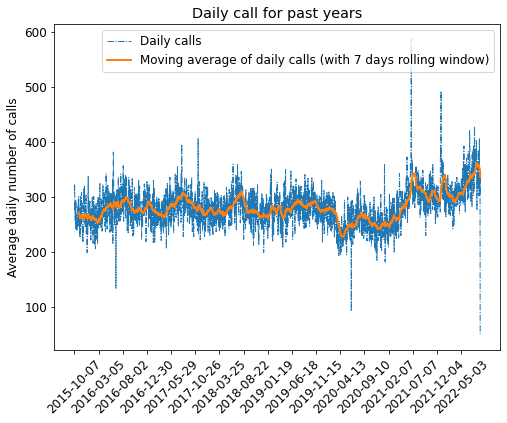

In [5]:
rolling_window = 30 #days
grouped_df = preprocessing.group_df_func(df, ['year','month','day'], date_col = True)
grouped_df = grouped_df.iloc[-12*7*30:].reset_index(drop=True)
fig, ax = plt.subplots()
ax.plot(grouped_df.num_calls, ls= '-.', label = 'Daily calls', linewidth = 1)
ax.plot(grouped_df.num_calls.rolling(rolling_window).sum()/rolling_window, label = 'Moving average of daily calls (with 7 days rolling window)', linewidth = 2)
ax.set_ylabel('Average daily number of calls')
ax.set_xticks(np.arange(len(grouped_df.date))[0::150])
_ = ax.set_xticklabels(grouped_df.date[0::150], rotation=45)
ax.set_title('Daily call for past years')
plt.legend()
plt.show()

### Trend, sesonality and residual check on the original time series

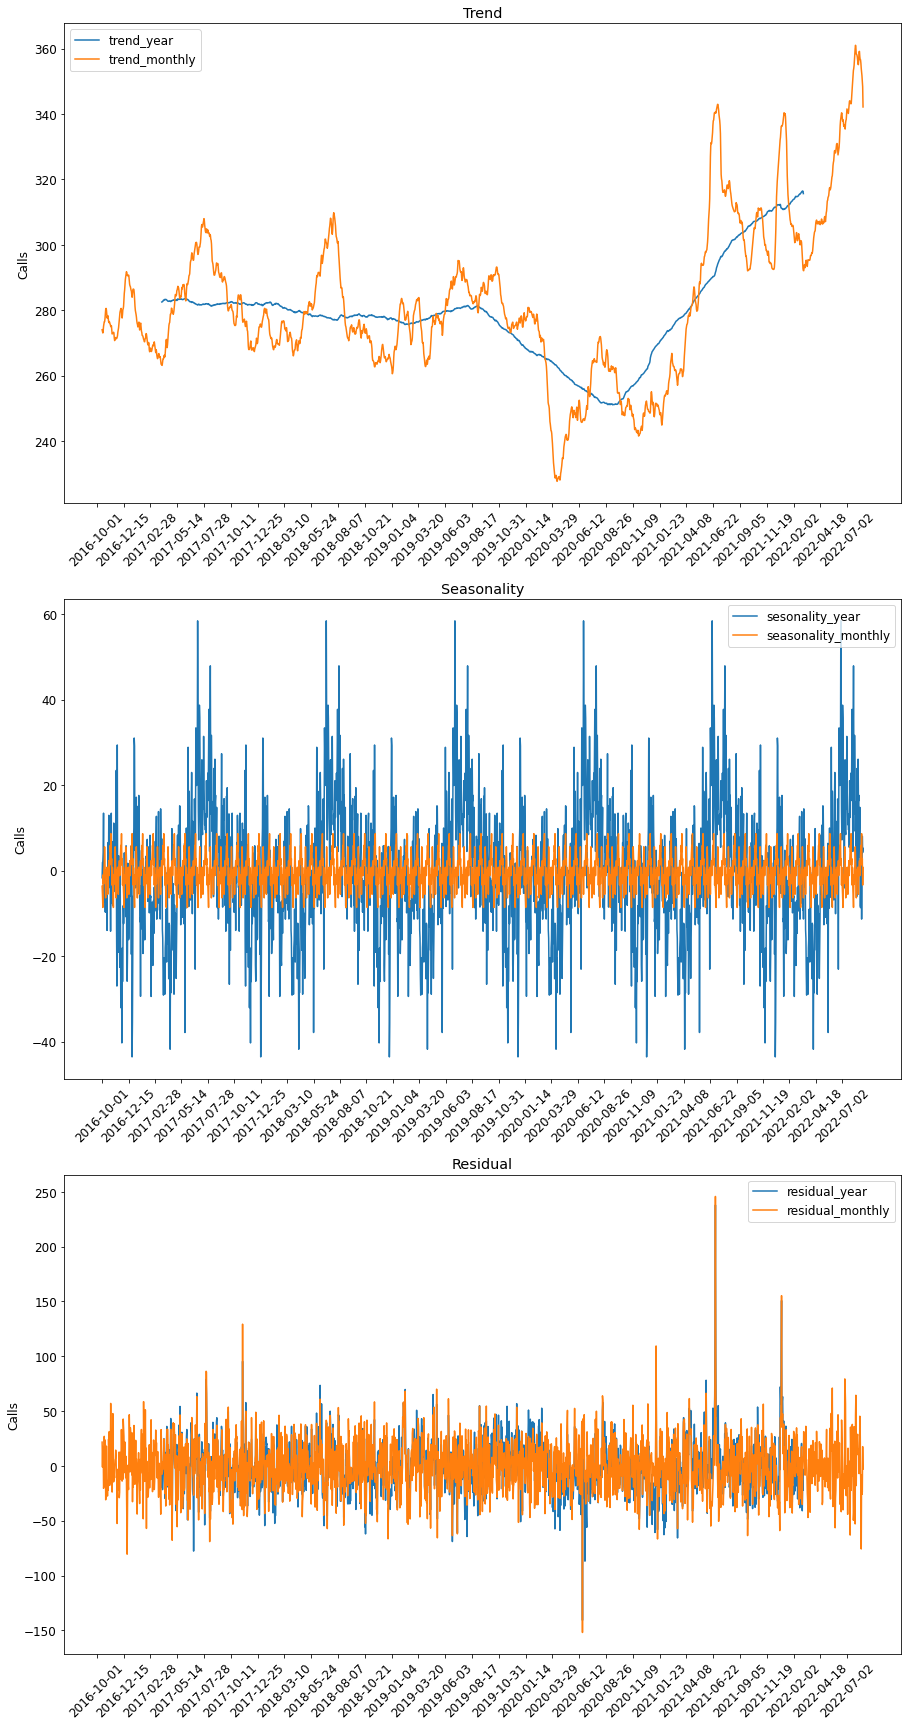

In [6]:
grouped_df = preprocessing.group_df_func(df, ['year','month','day'], date_col = True)
grouped_df = grouped_df.iloc[-30*12*6:].reset_index(drop=True)

res_year = seasonal_decompose(grouped_df.num_calls, model = "additive",period = 365)
res_month = seasonal_decompose(grouped_df.num_calls, model = "additive",period = 30)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,30))

res_year.trend.plot(ax=ax1)
res_month.trend.plot(ax=ax1)
ax1.set_ylabel('Calls')
ax1.set_title('Trend')
ax1.legend(['trend_year', 'trend_monthly'])
ax1.set_xticks(np.arange(len(grouped_df.date))[0::75])
_ = ax1.set_xticklabels(grouped_df.date[0::75], rotation=45)

res_year.seasonal.plot(ax=ax2)
res_month.seasonal.plot(ax=ax2)
ax2.set_ylabel('Calls')
ax2.set_title('Seasonality')
ax2.legend(['sesonality_year', 'seasonality_monthly'])
ax2.set_xticks(np.arange(len(grouped_df.date))[0::75])
_ = ax2.set_xticklabels(grouped_df.date[0::75], rotation=45)

res_year.resid.plot(ax=ax3)
res_month.resid.plot(ax=ax3)
ax3.set_ylabel('Calls')
ax3.set_title('Residual')
ax3.legend(['residual_year', 'residual_monthly'])
ax3.set_xticks(np.arange(len(grouped_df.date))[0::75])
_ = ax3.set_xticklabels(grouped_df.date[0::75], rotation=45)
plt.show()

## Analysis of calls with respect to the type of call 

In [7]:
# import plotly.express as px

# grouped_type = preprocessing.group_df_func(df, ['year','type'], date_col = False)
# grouped_type = grouped_type.sort_values(['year', 'num_calls'], ascending=[True, False])

# temp = pd.DataFrame()
# for year in grouped_type.year.unique()[1:]:
#     temp = pd.concat([temp, grouped_type[grouped_type['year'] == year].iloc[:10]], axis = 0)
# temp
    
    
# fig = px.bar(temp, x='type', y="num_calls", color=list(map(str,temp['year'])),
#              width=950, height=800, labels = {'y_point': "Lens point"})
# fig.update_layout(title_text = 'Top 10 reasons of 911 calls of each year over the years', 
#                   title_x = 0.5, yaxis_title = 'Number of calls', xaxis_title = 'Type of call', legend_title="Year")
# fig.show()

# fig = px.scatter(temp, x='year', y="num_calls", color='type',
#              width=950, height=800, labels = {'y_point': "Lens point"})
# fig.update_layout(title_text = 'Trend of given 911 call types over the years', 
#                   title_x = 0.5, yaxis_title = 'Number of calls', xaxis_title = 'Year', legend_title="Type of call")
# for d in range(len(fig.data)):
#             fig.data[d].update(mode='markers+lines')
# fig.show()

## Findings
The findings are as follows:
1. The average daily calls exhibit a rising trend
2. There appears to be a cyclic nature in the number of daily calls for the years before 2019 end
2. The end of 2019 was also the onset of covid pandemic
3. During covid (2019 end till mid of 2021) it can be seen that the 911 calls had reduced a lot
4. More information is required to predict the daily calls during the time after covid.
5. Moreover daily calls have risen considerably after mid of 2021
6. There is an annual and a montly seasonality in the time series.
7. The noise component of the time series is very high

###  Modeling is done to predict the daily calls for the last month of 2022 using last 5 years as the training data without using past values as input to the model

,year,month,day,dayofweek,num_calls
0,2012,8,19,6,37
1,2012,8,20,0,249
2,2012,8,21,1,236
3,2012,8,22,2,232
4,2012,8,23,3,223


The mean squared error is: 1989.7144860861972
The mean absolute error is: 38.119269248270406


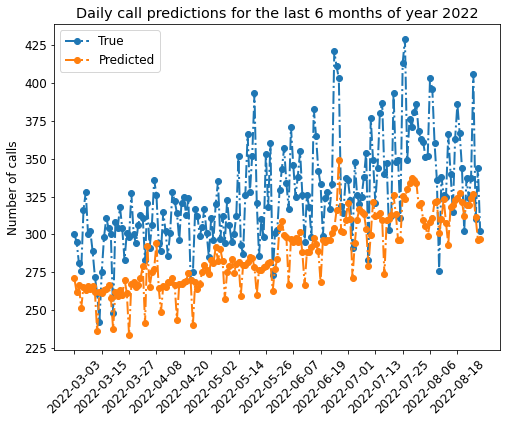

The mean squared error is: 1935.15288437912
The mean absolute error is: 35.97397697786955


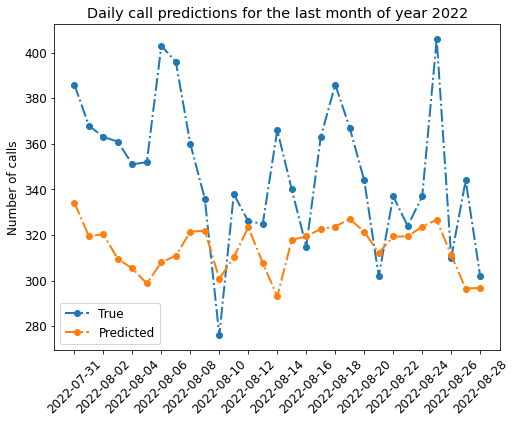

In [8]:
## grouping with respect to year, month, day and dayofweek for the number of cases reported that day
grouped_df = preprocessing.group_df_func(df, ['year', 'month', 'day','dayofweek'], date_col = False)

display(grouped_df.head(5))

temp = weather.copy()
temp = temp.groupby(['year','month','day']).mean().reset_index()
grouped_df = pd.concat([grouped_df,temp[['tempC','windspeedKmph']]], axis = 1).iloc[:-1]

## current year as test dataset and last 5 years as training dataset
test_df = grouped_df[grouped_df['year'] == 2022].reset_index(drop=True) #year 2022
train_df = grouped_df[(grouped_df['year'] < 2022) & (grouped_df['year'] > 2016)].reset_index(drop=True) #year 2021 to 2017

model_daily = train.train_model(GradientBoostingRegressor(), train_df, test_df, 'daily', df.iloc[0].datetime.year)
results_df = test.test_model(model_daily,test_df[-180:], 'daily')
results_df = test.evaluate_predictions(results_df, 180, 'daily','Daily call predictions for the last 6 months of year 2022')

results_df = test.test_model(model_daily,test_df[-30:], 'daily')
results_df = test.evaluate_predictions(results_df, 30,'daily', 'Daily call predictions for the last month of year 2022')

##### It can be seen that the error is quite high when no previous information is provided

### Modeling is done to predict the daily calls for the last month of 2022 using last 5 years as the training data and also using previous values as input

Values shifted by 1,7,14 and 28 days have been augmented to the input dataframe

The mean squared error is: 976.1824359097644
The mean absolute error is: 23.995051998533913


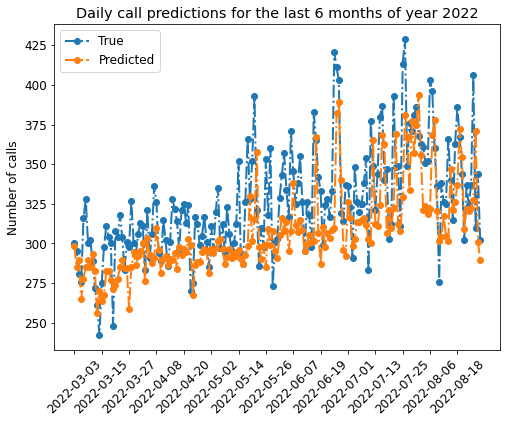

The mean squared error is: 1224.0498674725927
The mean absolute error is: 27.695838625837755


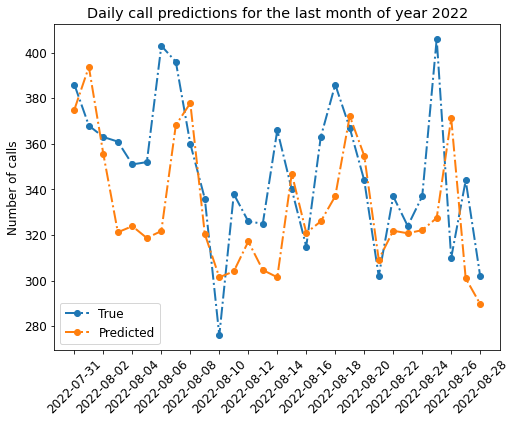

In [9]:
## grouping with respect to year, month, day and dayofweek for the number of cases reported that day
grouped_df = preprocessing.group_df_func(df, ['year', 'month', 'day','dayofweek'], date_col = False)

## last 5 shifted values of actual calls are augmented
for i in range(5):
    grouped_df['num_calls_prev'+str(i+1)] = grouped_df.num_calls.shift(i+1)


temp = weather.copy()
temp = temp.groupby(['year','month','day']).mean().reset_index()
grouped_df = pd.concat([grouped_df,temp[['tempC','windspeedKmph']]], axis = 1).iloc[:-1]

## current year as test dataset and last 5 years as training dataset
test_df = grouped_df[grouped_df['year'] == 2022].reset_index(drop=True) #year 2022
train_df = grouped_df[(grouped_df['year'] < 2022) & (grouped_df['year'] > 2016)].reset_index(drop=True) #year 2021 to 2017

model_daily = train.train_model(GradientBoostingRegressor(), train_df, test_df, 'daily', df.iloc[0].datetime.year)
results_df = test.test_model(model_daily,test_df[-180:], 'daily')
results_df = test.evaluate_predictions(results_df, 180, 'daily','Daily call predictions for the last 6 months of year 2022')

results_df = test.test_model(model_daily,test_df[-30:], 'daily')
results_df = test.evaluate_predictions(results_df, 30,'daily', 'Daily call predictions for the last month of year 2022')

##### It can be seen that the error reduces by a great margin

### Modeling is done to predict the daily calls for the last month of 2018 using last 4 years as the training data, as covid shows a lot of change in the daily call pattern after 2019

The mean squared error is: 559.0195064780165
The mean absolute error is: 18.897599124825202


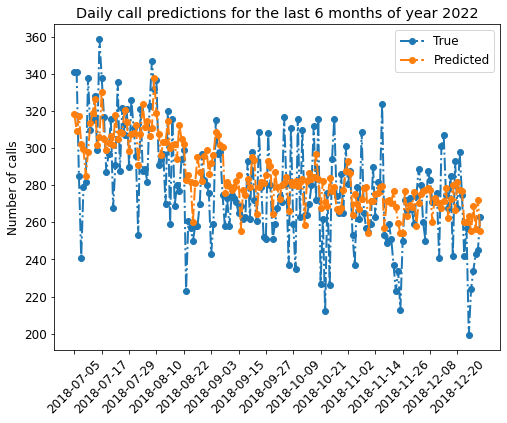

The mean squared error is: 526.9343026838906
The mean absolute error is: 17.972337581977854


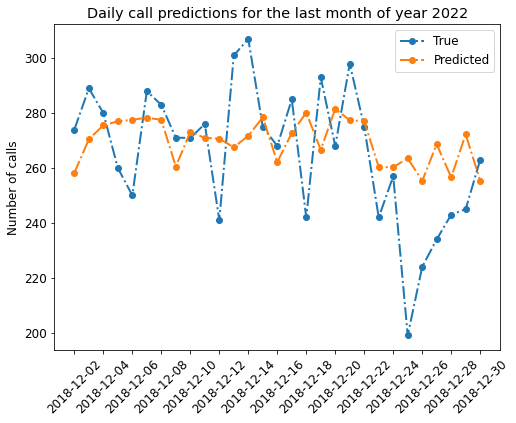

In [10]:
## grouping with respect to year, month, day and dayofweek for the number of cases reported that day
grouped_df = preprocessing.group_df_func(df, ['year', 'month', 'day','dayofweek'], date_col = False)

## previous information
for i in range(5):
    grouped_df['num_calls_prev'+str(i+1)] = grouped_df.num_calls.shift(i+1)


temp = weather.copy()
temp = temp.groupby(['year','month','day']).mean().reset_index()
grouped_df = pd.concat([grouped_df,temp[['tempC','windspeedKmph']]], axis = 1).iloc[:-1]

## 2018 year as test dataset and last 4 or 5 years as training dataset
test_df = grouped_df[grouped_df['year'] == 2018].reset_index(drop=True) #year 2018
train_df = grouped_df[(grouped_df['year'] < 2018) & (grouped_df['year'] > 2014)].reset_index(drop=True) #year 2021 to 2017

model_daily = train.train_model(GradientBoostingRegressor(), train_df, test_df, 'daily', df.iloc[0].datetime.year)
results_df = test.test_model(model_daily,test_df[-180:], 'daily')
results_df = test.evaluate_predictions(results_df, 180, 'daily','Daily call predictions for the last 6 months of year 2022')

results_df = test.test_model(model_daily,test_df[-30:], 'daily')
results_df = test.evaluate_predictions(results_df, 30,'daily', 'Daily call predictions for the last month of year 2022')

## Modelling findings:

1. The mean absolute error between the prediction and the true value for a month of 2018 is almost 40% lesser than that of 2022.
2. This also suggests that more information/features is/are required to model the change that has happened after covid, if the last 5 years data is to be used for training. OR We can try to model using past few months data before 2022 last month
3. Providing previous information improved the modelling results
4. Moreover, there is a lot of noise component present in the time series, which requires a different model to model it correctly.

### Modelling last month of 2022 again using past 18 months data. i.e. after covid

The mean squared error is: 827.04778012473
The mean absolute error is: 23.057973834747138


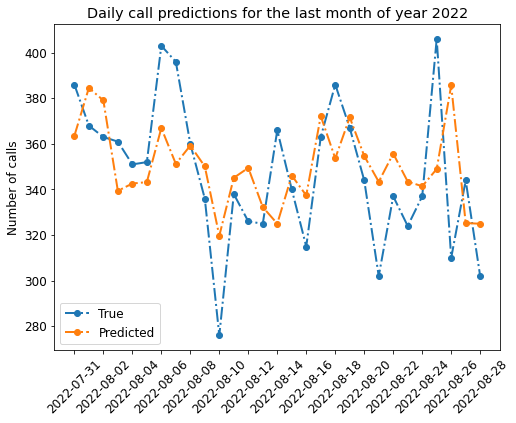

In [11]:
## grouping with respect to year, month, day and dayofweek for the number of cases reported that day
grouped_df = preprocessing.group_df_func(df, ['year', 'month', 'day','dayofweek'], date_col = False)

for i in range(5):
    grouped_df['num_calls_prev'+str(i+1)] = grouped_df.num_calls.shift(i+1)


temp = weather.copy()
temp = temp.groupby(['year','month','day']).mean().reset_index()
grouped_df = pd.concat([grouped_df,temp[['tempC','windspeedKmph']]], axis = 1).iloc[:-1]

## current month as test dataset and last 18 months as training dataset
test_df = grouped_df.iloc[-30:]
train_df = grouped_df.iloc[-30*18:-30]

model_daily = train.train_model(GradientBoostingRegressor(), train_df, test_df, 'daily', df.iloc[0].datetime.year)
results_df = test.test_model(model_daily,test_df, 'daily')
results_df = test.evaluate_predictions(results_df, 30,'daily', 'Daily call predictions for the last month of year 2022')

#####  It was observed that the predictions improved when the model was trained only on the past 18 months to predict the last month of 2022.